In [2]:
if (!require(survRM2)) install.packages('survRM2')
library('survRM2') 
if (!require(mvtnorm)) install.packages('mvtnorm')
library('mvtnorm')
if (!require(survival)) install.packages('survival')
library('survival')
if (!require(nph)) install.packages('nph')
library('nph')
if (!require(foreach)) install.packages("foreach")
library('foreach') 
if (!require(doParallel)) install.packages("doParallel")
library('doParallel')
if (!require(ggplot2)) install.packages("ggplot2")
library('ggplot2')
if (!require(cowplot)) install.packages("cowplot")
library('cowplot')
library('simtrial')

n_cores <- detectCores()
cluster <- makeCluster(14) # How many cores we use
registerDoParallel(cluster)
# multi thread
invisible(clusterEvalQ(cluster, #import packages to parallel 
  {
  library('survRM2')
  library('mvtnorm')
  library('survival')
  library('nph')
  library("simtrial")
  library("foreach")
  }))

source('Rfiles/Function.R')
clusterExport(cluster, "expo_gen_2stages")

# NPH Early Difference

#### Reference: Shan(2021) (https://doi.org/10.1016/j.conctc.2021.100732)
#### But this paper is single arm two stages simple RMST. We are double
#### We use the non-HR setting in Eaton(2020) (One stage two sided test)
####  <span style="color:yellow">Early differenct: A hazard ratio of 0.67 until 15 months and then a hazard ratio of 1.2. acc_time = 24, cen_time = 36, interim = 18, final $\tau = 48$
-----
## We added a Interim Period Under Non Proportional Hazard
####  $\textcolor{yellow}{H_0 : \lambda_0 = \lambda_1 = log(2)/10}$    
####  $\textcolor{yellow}{H_1 : \lambda_0 = log(2)/10,\ \lambda_1 = Piecewise\ Exponential}$

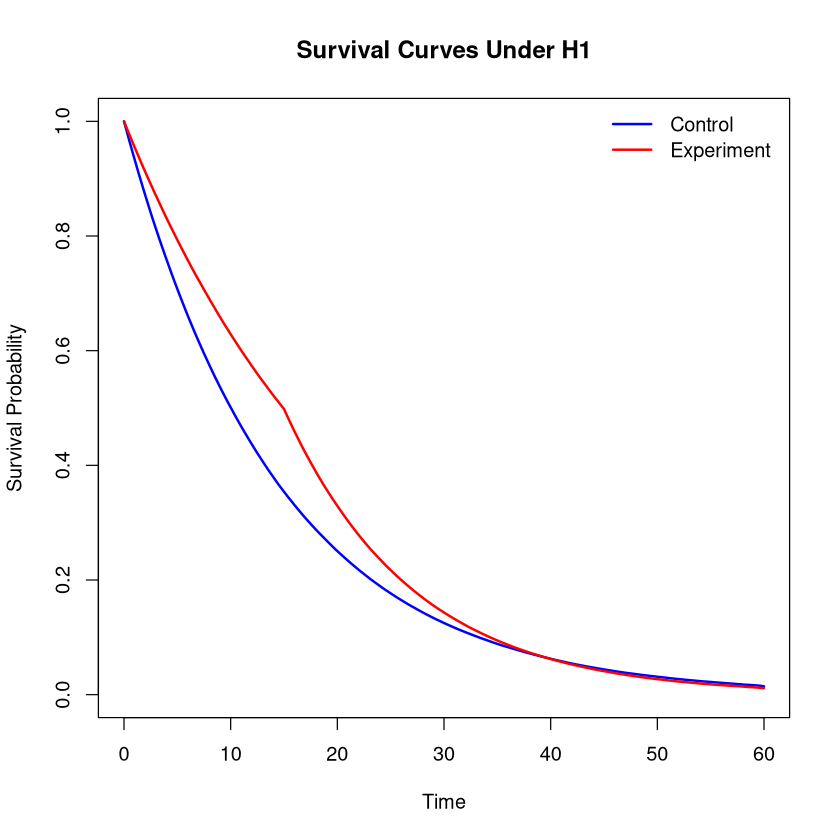

In [3]:
median_con <- 10 # month
lambda_H0 <- log(2)/median_con
HR1 <- 0.67
HR2 <- 1.2
sim_size <- 10000 
acc_time <- 24
cen_time <- 36
n <- 100  # Fix total sample size
interim <- 18
change_time <- 15
set.seed(2024)

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0,
                         dist = 'exp', cen_time = cen_time, arm = 0, interim = interim)
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, 
                         dist = 'exp', cen_time = cen_time, arm = 1, interim = interim)                         
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, 
                          dist = 'pcw_exp', cen_time = cen_time,HR1 = HR1, HR2 = HR2, 
                          change_time = change_time, arm = 1, interim = interim)

pre_data <- rbind(data_C[ , c(4,5,1)], data_E_H1[ , c(4,5,1)])
fit <- survfit(Surv(pre_data[,1], pre_data[,2]) ~ pre_data[,3])
plot(fit, col = c("blue", "red"), lwd = 2, xlab = "Time", ylab = "Survival Probability", main = "Survival Curves Under H1")
legend("topright", legend = c("Control", "Experiment"), col = c("blue", "red"), lwd = 2, bty = "n")

#calculate the RMST of each group in H0,H1
data_C_int <- data_C[ , c(2,3,1)]  
data_E_H0_int <- data_E_H0[ , c(2,3,1)]
data_E_H1_int <- data_E_H1[ , c(2,3,1)]
rmst_h0_int <- RMST_sim_cal(n = n,data_E = data_E_H0_int, data_C = data_C_int,tau = interim,sim_size = sim_size)
rmst_h1_int <- RMST_sim_cal(n = n,data_E = data_E_H1_int, data_C = data_C_int,tau = interim,sim_size = sim_size)

data_C_fin <- data_C[ , c(4,5,1)]
data_E_H0_fin <- data_E_H0[ , c(4,5,1)]
data_E_H1_fin <- data_E_H1[ , c(4,5,1)]
rmst_h0_fin <- RMST_sim_cal(n = n,data_E = data_E_H0_fin, data_C = data_C_fin,tau = 48,sim_size = sim_size)
rmst_h1_fin <- RMST_sim_cal(n = n,data_E = data_E_H1_fin, data_C = data_C_fin,tau = 48,sim_size = sim_size)
rmst_data <- rbind(rmst_h0_int, rmst_h1_int, rmst_h0_fin, rmst_h1_fin)

### 1. Simple RMST Difference
#### E and C are RMST value of experiment group and control group repectively
#### Rejection region of Interim:
#### $\textcolor{lightgreen}{E(\tau_1) - C(\tau_1) > m_1}$
#### Rejection region of overall:
#### $ \textcolor{lightgreen}{E(\tau_1) - C(\tau_1) > m_1\ \&\  E(\tau_2)-C(\tau_2)>m_2 }$
#### <font color=LightSeaGreen>Use the same find_m_t function.  Set t_low = $-Inf$ to find the best m1, m2


In [5]:
find_m_t_RMST(m_low = -3, t_low = -Inf, t_up = 0, rmst_data = rmst_data, search_times = 5000, search_step = 0.002,
         tar_a1 = 0.85, tar_pow1_low = 0.1, tar_a2 = 0.1, sim_size = 10000)

m1,t1,PET0,PET1,m2,t2,alpha,Power
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-1.244,-Inf,0.1501,0.0071,2.286,-Inf,0.0998,0.5455


### 2. Our RMST Rejection method
#### $ \textcolor{lightgreen}{E(\tau_1)-C(\tau_1)>m_1\ \&\  E(\tau_1)>t_1\ \&\  E(\tau_2)-C(\tau_2)>m_2\ \&\  E(\tau_2)>t_2}$

In [6]:
find_m_t_RMST(m_low = -3, t_low = 8, t_up = 15, rmst_data = rmst_data, search_times = 1000, search_step = 0.005,
         tar_a1 = 0.85, tar_pow1_low = 0.1, tar_a2 = 0.1, sim_size = 10000)

m1,t1,PET0,PET1,m2,t2,alpha,Power
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-2.205,9.022,0.1508,5e-04,1.795,15,0.0998,0.6288


### 3. Log rank test
#### $\textcolor{lightgreen}{\frac{W_1}{\sigma_1}>c_1\ \&\ \frac{W}{\sigma}>c}$

In [7]:
z_stats_h0_int <- log_rank_sim(data_C = data_C_int, data_E = data_E_H0_int, sim_size =  sim_size,
                            n = n, alpha = 0.1, sided = 'greater')$z_stats
z_stats_h1_int <- log_rank_sim(data_C = data_C_int, data_E = data_E_H1_int, sim_size =  sim_size,
                            n = n, alpha = 0.1, sided = 'greater')$z_stats
z_stats_h0_fin <- log_rank_sim(data_C = data_C_fin, data_E = data_E_H0_fin, sim_size =  sim_size,
                            n = n, alpha = 0.1, sided = 'greater')$z_stats
z_stats_h1_fin <- log_rank_sim(data_C = data_C_fin, data_E = data_E_H1_fin, sim_size =  sim_size,
                            n = n, alpha = 0.1, sided = 'greater')$z_stats
logrank_data <- rbind(z_stats_h0_int, z_stats_h1_int, z_stats_h0_fin, z_stats_h1_fin)                 

In [8]:
find_m_logrank(m_low = -2,logrank_data = logrank_data, search_times = 4000, search_step = 0.001,
                tar_a1 = 0.85, tar_pow1_low = 0.1, tar_a2 = 0.1, sim_size = 10000)

m1,PET0,PET1,m2,alpha,Power
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-1.041,0.1501,0.0065,1.281,0.0997,0.4573


----

## <span style="color:yellow">Optimal trial ( Min(EN) )
#### Stage I (Interim = 198) type I error can be set and $PET_0=1-\alpha_1 $
#### Under each $\alpha_1$ we can get empirical $power_1 = 1-PET_1$
#### We can search for the best $\alpha_1$ to minimize EN reach the overall alpha and power.

In [11]:
PET0 <- 0.2

s1result <- RMST_sim_test(n = 100, data_C = data_C[ , c(2, 3 ,1)] , data_E = data_E_H1[ , c(2, 3, 1)],
                     tau = interim , sim_size = sim_size, alpha = 1-PET0, sided = 'greater')
power_1 <- s1result$test_result$Rejection
PET1 <- 1 - power_1

s2result_H0 <- RMST_sim_test(n = 100, data_C = data_C[ , c(4, 5, 1)] , data_E = data_E_H0[ , c(4, 5, 1)],
                     tau = 48 , sim_size = sim_size, alpha = 1 - PET0, sided = 'greater')
s2result_H1 <- RMST_sim_test(n = 100, data_C = data_C[ , c(4, 5, 1)] , data_E = data_E_H0[ , c(4, 5, 1)],
                     tau = 48 , sim_size = sim_size, alpha = 1 - PET0, sided = 'greater')
 



[1] 0.0499

In [10]:
power_1

[1] 0.3764